## Main

### Training

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, set_seed
import evaluate
import torch
import os
import numpy as np
from tqdm import tqdm
from datasets import load_from_disk, DatasetDict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import gc

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
set_seed(seed)

lr = 1e-4
batch_size = 32
num_epochs = 2

# os.environ["CUDA_VISIBLE_DEVICES"]="0"

model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name, padding='left')
orig_tokenizer = AutoTokenizer.from_pretrained('EleutherAI/pythia-12b')
path = '../../../gld/train-data-probes/data/12b'
dataset = load_from_disk(os.path.join(path, 'split_hf_token_dataset_vary_len_v2'))
id2label = {0: 'neg', 1: 'pos'}
label2id = {'neg': 0, 'pos': 1}
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, id2label=id2label, label2id=label2id)
model.to('cuda')
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))
# tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
# def preprocess(examples): 
#     return {'input_ids': tokenizer(examples['ground_str'], padding='max_length', truncation=True, max_length=64, return_tensors='pt')['input_ids']}

# dataset = dataset.map(preprocess, batched=True)
# dataset

In [3]:
# from datasets import load_from_disk, DatasetDict, Dataset
# import numpy as np

# seed = 0
# np.random.seed(seed)

# print(len(dataset))

# dataset = dataset.shuffle(seed=seed)
# dataset = dataset.train_test_split(test_size=0.3)
# test = dataset['test']
# temp = dataset['train'].train_test_split(test_size=1/7)
# train = temp['train']
# val = temp['test']
# dataset = DatasetDict({'train': train, 'val': val, 'test': test})

# tok_idxs =  (7 * np.arange(10)).tolist() #every 5th token
# tok_idxs[-1]= tok_idxs[-1] - 1 #goes from 63 to 62
# print(tok_idxs)

# # cutoff after 64 tokens
# input_ids = {'train': [], 'val': [], 'test': []}
# texts = {'train': [], 'val': [], 'test': []}
# labels = {'train': [], 'val': [], 'test': []}
# orig_idx = {'train': [], 'val': [], 'test': []}
# for cutoff in tok_idxs[5:]: 
#     print(cutoff)
#     for split in ['train', 'val', 'test']:
#         input_ids[split].extend([x[:cutoff] for x in dataset[split]['input_ids']])
#         texts[split].extend(dataset[split]['ground_str'])
#         labels[split].extend([int(x) for x in dataset[split]['pythia_label']])
#         orig_idx[split].extend(dataset[split]['orig_idx'])

# dataset = DatasetDict({'train': Dataset.from_dict({'input_ids': input_ids['train'], 'text': texts['train'], 'labels': labels['train'], 'orig_idx': orig_idx['train']}),
#                           'val': Dataset.from_dict({'input_ids': input_ids['val'], 'text': texts['val'], 'labels': labels['val'], 'orig_idx': orig_idx['val']}),
#                           'test': Dataset.from_dict({'input_ids': input_ids['test'], 'text': texts['test'], 'labels': labels['test'], 'orig_idx': orig_idx['test']})})

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'df_ref_idx'],
        num_rows: 20235
    })
    val: Dataset({
        features: ['input_ids', 'labels', 'df_ref_idx'],
        num_rows: 3375
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'df_ref_idx'],
        num_rows: 10120
    })
})

In [5]:
# pad datasets

# def tokenize(example): 
#     return {'input_ids': tokenizer(example['text'], padding='max_length', truncation=True, max_length=64)['input_ids']}

# dataset['train'] = dataset['train'].map(tokenize, batched=False)
# dataset['val'] = dataset['val'].map(tokenize, batched=False)
# dataset['test'] = dataset['test'].map(tokenize, batched=False)

def retokenize(example): 
    return {'input_ids': tokenizer(orig_tokenizer.decode(example['input_ids']), padding='max_length', truncation=True, max_length=64, return_tensors='pt')['input_ids'][0]}

dataset['train'] = dataset['train'].map(retokenize, batched=False)
dataset['val'] = dataset['val'].map(retokenize, batched=False)
dataset['test'] = dataset['test'].map(retokenize, batched=False)

max_train_len = max([len(x['input_ids']) for x in dataset['train']])
max_val_len = max([len(x['input_ids']) for x in dataset['val']])
max_test_len = max([len(x['input_ids']) for x in dataset['test']])

def preprocess(examples): 
    curr_len = len(examples['input_ids'])
    if curr_len < max_train_len:
        examples['input_ids'] = examples['input_ids'] + [tokenizer.pad_token_id]*(max_train_len-curr_len)
    return examples

dataset['train'] = dataset['train'].map(preprocess)
dataset['val'] = dataset['val'].map(preprocess)
dataset['test'] = dataset['test'].map(preprocess)

print(max_train_len, max_val_len, max_test_len)

Map:   0%|          | 0/20235 [00:00<?, ? examples/s]

Map: 100%|██████████| 10120/10120 [00:00<00:00, 10892.52 examples/s]

64 64 64


In [6]:
train_lens = [len(x['input_ids']) for x in dataset['train']]
val_lens = [len(x['input_ids']) for x in dataset['val']]
test_lens = [len(x['input_ids']) for x in dataset['test']]

assert set(train_lens) == set(val_lens) == set(test_lens)

In [7]:
def tpr_at_fpr(probs, labels, target_fpr, left=0.5, right=1.0, max_steps=1000, thresh_tol=1e-6): 
    """
    Calculates the true positive rate at a given false positive rate. 
    Does up to max_steps steps of binary search, returns the best guess 
    that yields a false positive rate less than target_fpr
    
    probs: (n_examples, ) just prob on positive class
    labels: (n_examples, ) 0 or 1
    """
    assert len(probs) == len(labels)
    assert probs.shape == labels.shape
    assert probs.shape[0] > 0

    for _ in range(max_steps):
        mid = (left + right) / 2
        
        # calc fpr 
        preds = (probs > mid).astype(int)
        fp = np.logical_and(preds == 1, labels == 0).sum()
        tn = (labels == 0).sum()
        fpr = fp / tn if tn > 0 else 0

        if abs(fpr - target_fpr) < thresh_tol: 
            right = mid
            break
        elif fpr > target_fpr:
            left = mid
        else:
            right = mid
    
    # use right as threshold to ensure fpr <= target_fpr
    preds = (probs > right).astype(int)
    tp = np.logical_and(preds == 1, labels == 1).sum()
    fn = (labels == 1).sum()
    return tp / fn if fn > 0 else 0

In [11]:
loss_fn = torch.nn.CrossEntropyLoss()
data = {'val_loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'AUC': [], 'tpr_01': [], 'tpr_001': [], 'tpr_0001': []}

def compute_metrics(eval_pred):
    
    logits, labels = eval_pred
    logits = np.array(logits) # (n_examples, n_classes)
    labels = np.array(labels) # (n_examples)

    preds = np.argmax(logits, axis=1)
    normalized_prob = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
    positive_prob = normalized_prob[:, 1]
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    auc = roc_auc_score(labels, positive_prob)
    
    # loss = loss_fn(torch.tensor(logits), torch.tensor(labels))

    # calculate tpr at fpr = 0.01, 0.001, and 0.0001
    tpr_01 = tpr_at_fpr(positive_prob, labels, 0.01)
    tpr_001 = tpr_at_fpr(positive_prob, labels, 0.001)
    tpr_0001 = tpr_at_fpr(positive_prob, labels, 0.0001)

    # log
    data['accuracy'].append(acc)
    data['precision'].append(precision)
    data['recall'].append(recall)
    data['f1'].append(f1)
    data['AUC'].append(auc)
    data['tpr_01'].append(tpr_01)
    data['tpr_001'].append(tpr_001)
    data['tpr_0001'].append(tpr_0001)

    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'AUC': auc, 'tpr_01': tpr_01, 'tpr_001': tpr_001, 'tpr_0001': tpr_0001}

In [12]:
targs = TrainingArguments(
            output_dir = os.path.join(path, 'finetuning/final'),
            evaluation_strategy = 'epoch',
            logging_strategy = 'epoch',
            save_strategy='epoch',
            learning_rate=lr,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=128,
            num_train_epochs=1,
            save_total_limit=10,
            load_best_model_at_end=True,
            metric_for_best_model='accuracy',
            weight_decay=0.01,
            report_to='none',
            seed=seed,
            eval_accumulation_steps=1,
        )

trainer = Trainer(
            model=model,
            tokenizer=tokenizer, 
            args=targs,
            train_dataset=dataset['train'],
            eval_dataset=dataset['val'], 
            compute_metrics=compute_metrics,
        )

In [14]:
trainer.train()

/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Tpr 01,Tpr 001,Tpr 0001
1,0.033500,0.771511,0.861926,0.859587,0.864688,0.862130,0.907961,0.230267,0.048071,0.039169


Checkpoint destination directory ../../../gld/train-data-probes/data/12b/finetuning/final/checkpoint-159 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=159, training_loss=0.03349906693464555, metrics={'train_runtime': 47.0826, 'train_samples_per_second': 429.777, 'train_steps_per_second': 3.377, 'total_flos': 335059726475520.0, 'train_loss': 0.03349906693464555, 'epoch': 1.0})

In [15]:
model.save_pretrained(os.path.join(path, 'finetuning/distilbert-base-uncased'))

### Evaluation

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, set_seed
import evaluate
import torch
import os
import numpy as np
from tqdm import tqdm
from datasets import load_from_disk, DatasetDict, Dataset, concatenate_datasets
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import gc
import sys
sys.path.append('..')
from utils import tpr_at_fpr

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
set_seed(seed)

os.environ["CUDA_VISIBLE_DEVICES"]="0"
torch.cuda.set_device(0)

model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name, padding='left')
orig_tokenizer = AutoTokenizer.from_pretrained('EleutherAI/pythia-12b')

path = '../../../gld/train-data-probes/data/12b'
dataset = load_from_disk(os.path.join(path, 'split_hf_token_dataset_vary_len_v2'))
generalization_datasets = load_from_disk(os.path.join(path, 'generalization_datasets_unbalanced'))
id2label = {0: 'neg', 1: 'pos'}
label2id = {'neg': 0, 'pos': 1}
model = AutoModelForSequenceClassification.from_pretrained(os.path.join(path, 'finetuning/distilbert-base-uncased'), num_labels=2, id2label=id2label, label2id=label2id)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id

/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
# # pad datasets
# def tokenize(example): 
#     return {'input_ids': tokenizer(example['text'], padding='max_length', truncation=True)['input_ids']}

# dataset['train'] = dataset['train'].map(tokenize, batched=False)
# dataset['val'] = dataset['val'].map(tokenize, batched=False)
# dataset['test'] = dataset['test'].map(tokenize, batched=False)

def retokenize(example): 
    return {'input_ids': tokenizer(orig_tokenizer.decode(example['input_ids']), padding='max_length', truncation=True, max_length=64, return_tensors='pt')['input_ids'][0]}

dataset['train'] = dataset['train'].map(retokenize, batched=False)
dataset['val'] = dataset['val'].map(retokenize, batched=False)
dataset['test'] = dataset['test'].map(retokenize, batched=False)

max_train_len = max([len(x['input_ids']) for x in dataset['train']])
max_val_len = max([len(x['input_ids']) for x in dataset['val']])
max_test_len = max([len(x['input_ids']) for x in dataset['test']])

def preprocess(examples, max_len): 
    curr_len = len(examples['input_ids'])
    if curr_len < max_train_len:
        examples['input_ids'] = examples['input_ids'] + [tokenizer.pad_token_id]*(max_len-curr_len)
    return examples

dataset['train'] = dataset['train'].map(lambda x: preprocess(x, max_train_len))
dataset['val'] = dataset['val'].map(lambda x: preprocess(x, max_val_len))
dataset['test'] = dataset['test'].map(lambda x: preprocess(x, max_test_len))

dataset

Map: 100%|██████████| 10120/10120 [00:00<00:00, 10693.39 examples/s]


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'df_ref_idx'],
        num_rows: 20235
    })
    val: Dataset({
        features: ['input_ids', 'labels', 'df_ref_idx'],
        num_rows: 3375
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'df_ref_idx'],
        num_rows: 10120
    })
})

In [3]:
generalization_datasets

DatasetDict({
    fuzzy_pos: Dataset({
        features: ['input_ids', 'labels', 'df_ref_idx'],
        num_rows: 2510
    })
    prefix: Dataset({
        features: ['input_ids', 'labels', 'df_ref_idx'],
        num_rows: 10120
    })
    quotes: Dataset({
        features: ['text', 'labels'],
        num_rows: 190
    })
    songs: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 508
    })
    emails_no_context: Dataset({
        features: ['text', 'label'],
        num_rows: 9890
    })
})

In [4]:
# pad datasets

def preprocess(example): 
    return {'input_ids': orig_tokenizer(example['text'], return_tensors='pt')['input_ids'][0]}

generalization_datasets['prefix'] = generalization_datasets['prefix'].map(retokenize)
generalization_datasets['fuzzy_pos'] = generalization_datasets['fuzzy_pos'].map(retokenize)
# generalization_datasets['non_embedding_separable'] = generalization_datasets['non_embedding_separable'].map(preprocess)
generalization_datasets['quotes'] = generalization_datasets['quotes'].map(preprocess)
generalization_datasets['songs'] = generalization_datasets['songs'].map(retokenize)
generalization_datasets['emails_no_context'] = generalization_datasets['emails_no_context'].map(preprocess)

# # retokenize
# generalization_datasets['prefix'] = generalization_datasets['prefix'].map(retokenize)
# generalization_datasets['fuzzy_pos'] = generalization_datasets['fuzzy_pos'].map(retokenize)
# generalization_datasets['songs'] = generalization_datasets['songs'].map(retokenize)
# generalization_datasets['emails_no_context'] = generalization_datasets['emails_no_context'].map(retokenize)
# generalization_datasets['quotes'] = generalization_datasets['quotes'].map(retokenize)

max_prefix_len = max([len(x['input_ids']) for x in generalization_datasets['prefix']])
max_fuzzy_pos_len = max([len(x['input_ids']) for x in generalization_datasets['fuzzy_pos']])
# max_non_embedding_separable_len = max([len(x['input_ids']) for x in generalization_datasets['non_embedding_separable'])
max_quotes_len = max([len(x['input_ids']) for x in generalization_datasets['quotes']])
max_songs_len = max([len(x['input_ids']) for x in generalization_datasets['songs']])
max_emails_no_context_len = max([len(x['input_ids']) for x in generalization_datasets['emails_no_context']])

print(max_prefix_len, max_fuzzy_pos_len, max_quotes_len, max_songs_len, max_emails_no_context_len)                   
def preprocess(examples, max_len): 
    curr_len = len(examples['input_ids'])
    if curr_len < max_len:
        examples['input_ids'] = examples['input_ids'] + [tokenizer.pad_token_id]*(max_len-curr_len)
    return examples

generalization_datasets['prefix'] = generalization_datasets['prefix'].map(lambda x: preprocess(x, max_prefix_len))
generalization_datasets['fuzzy_pos'] = generalization_datasets['fuzzy_pos'].map(lambda x: preprocess(x, max_fuzzy_pos_len))
# generalization_datasets['non_embedding_separable'] = generalization_datasets['non_embedding_separable'].map(lambda x: preprocess(x, max_non_embedding_separable_len))
generalization_datasets['quotes'] = generalization_datasets['quotes'].map(lambda x: preprocess(x, max_quotes_len))
generalization_datasets['songs'] = generalization_datasets['songs'].map(lambda x: preprocess(x, max_songs_len))
generalization_datasets['emails_no_context'] = generalization_datasets['emails_no_context'].map(lambda x: preprocess(x, max_emails_no_context_len))

generalization_datasets

Map:   0%|          | 0/10120 [00:00<?, ? examples/s]

Map: 100%|██████████| 508/508 [00:00<00:00, 1336.20 examples/s]


64 64 34 64 19


Map: 100%|██████████| 9890/9890 [00:00<00:00, 13974.24 examples/s]


DatasetDict({
    fuzzy_pos: Dataset({
        features: ['input_ids', 'labels', 'df_ref_idx'],
        num_rows: 2510
    })
    prefix: Dataset({
        features: ['input_ids', 'labels', 'df_ref_idx'],
        num_rows: 10120
    })
    quotes: Dataset({
        features: ['text', 'labels', 'input_ids'],
        num_rows: 190
    })
    songs: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 508
    })
    emails_no_context: Dataset({
        features: ['text', 'label', 'input_ids'],
        num_rows: 9890
    })
})

In [5]:
# # get inputs that the model gets incorrect

# def get_incorrect_preds(dataset, model, tokenizer, batch_size=32):
#     """
#     Returns a dataset of incorrect predictions
#     """
#     model.eval()
#     incorrect_preds = []
#     for i in tqdm(range(0, len(dataset), batch_size)):
#         batch = dataset[i:i+batch_size]
#         input_ids = torch.tensor(batch['input_ids']).to('cuda')
#         labels = torch.tensor(batch['label']).to('cuda')
#         outputs = model(input_ids)
#         logits = outputs.logits
#         preds = torch.argmax(logits, axis=1)
#         incorrect_mask = (preds != labels)
#         # note batch is a dict of lists
#         print(incorrect_mask)
#         incorrect_batch = {k: v[incorrect_mask] for k, v in batch.items()}
#         incorrect_preds.append(incorrect_batch)
#     print(incorrect_preds)
#     return Dataset.from_dict(incorrect_preds)

# incorrect_preds = get_incorrect_preds(dataset['test'].select(range(500)), model, tokenizer, batch_size=32)


### prefix dataset

In [6]:
# prefix_dataset = load_from_disk(os.path.join(path, 'prefix_dataset_v0'))
# orig_tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-2-7b-hf')

In [7]:
# # detokenize

# def preprocess(example): 
#     return {'input_ids': tokenizer(orig_tokenizer.decode(example['input_ids']))['input_ids']}

# prefix_dataset = prefix_dataset.map(preprocess, batched=False)

# max_len = max([len(x['input_ids']) for x in prefix_dataset])
# def preprocess(example): 
#     curr_len = len(example['input_ids'])
#     if curr_len < max_len:
#         example['input_ids'] = example['input_ids'] + [tokenizer.pad_token_id]*(max_len-curr_len)
#     return example

# prefix_dataset = prefix_dataset.map(preprocess)

In [11]:
loss_fn = torch.nn.CrossEntropyLoss()
# data = {'val_loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'AUC': [], 'tpr_01': [], 'tpr_001': [], 'tpr_0001': []}

def compute_metrics(eval_pred, single_class=False): 
    
    logits, labels = eval_pred
    logits = np.array(logits) # (n_examples, n_classes)
    labels = np.array(labels) # (n_examples)

    preds = np.argmax(logits, axis=1)
    normalized_prob = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
    positive_prob = normalized_prob[:, 1]
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    if not single_class: 
        auc = roc_auc_score(labels, positive_prob)
    
    loss = loss_fn(torch.tensor(logits), torch.tensor(labels))

    # calculate tpr at fpr = 0.01, 0.001, and 0.0001
    tpr_01 = tpr_at_fpr(positive_prob, labels, 0.01)
    tpr_001 = tpr_at_fpr(positive_prob, labels, 0.001)
    tpr_0001 = tpr_at_fpr(positive_prob, labels, 0.0001)

    if single_class: 
        return {'val_loss': loss.item(), 'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'tpr_01': tpr_01, 'tpr_001': tpr_001, 'tpr_0001': tpr_0001}
    return {'val_loss': loss.item(), 'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'AUC': auc, 'tpr_01': tpr_01, 'tpr_001': tpr_001, 'tpr_0001': tpr_0001}

In [12]:
targs = TrainingArguments(
            output_dir = os.path.join(path, 'finetuning/final'),
            evaluation_strategy = 'epoch',
            logging_strategy = 'epoch',
            save_strategy='epoch',
            learning_rate=2e-5,
            per_device_train_batch_size=32,
            per_device_eval_batch_size=128,
            num_train_epochs=1,
            save_total_limit=10,
            load_best_model_at_end=True,
            metric_for_best_model='val_loss',
            weight_decay=0.01,
            report_to='none',
            seed=seed,
            eval_accumulation_steps=1,
        )

trainer = Trainer(
            model=model,
            tokenizer=tokenizer,
            args=targs,
            train_dataset=dataset['train'],
            eval_dataset=dataset['test'],
            compute_metrics=compute_metrics,
        )


In [13]:
trainer.evaluate()

{'eval_loss': 0.7698279619216919,
 'eval_val_loss': 0.7698279619216919,
 'eval_accuracy': 0.8603754940711462,
 'eval_precision': 0.8759811616954474,
 'eval_recall': 0.8510962821734985,
 'eval_f1': 0.8633594429939078,
 'eval_AUC': 0.9097031702964974,
 'eval_tpr_01': 0.1755958055290753,
 'eval_tpr_001': 0.011439466158245948,
 'eval_tpr_0001': 0.005910390848427073,
 'eval_runtime': 5.4022,
 'eval_samples_per_second': 1873.311,
 'eval_steps_per_second': 3.702}

In [14]:
targs = TrainingArguments(
            output_dir = os.path.join(path, 'finetuning/final'),
            evaluation_strategy = 'epoch',
            logging_strategy = 'epoch',
            save_strategy='epoch',
            learning_rate=2e-5,
            per_device_train_batch_size=32,
            per_device_eval_batch_size=128,
            num_train_epochs=1,
            save_total_limit=10,
            load_best_model_at_end=True,
            metric_for_best_model='val_loss',
            weight_decay=0.01,
            report_to='none',
            seed=seed,
            eval_accumulation_steps=1,
        )

trainer = Trainer(
            model=model,
            tokenizer=tokenizer,
            args=targs,
            train_dataset=dataset['train'],
            eval_dataset=generalization_datasets['prefix'],
            compute_metrics=compute_metrics,
        )

trainer.evaluate()

/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 2.7168972492218018,
 'eval_val_loss': 2.7168972492218018,
 'eval_accuracy': 0.5573122529644269,
 'eval_precision': 0.593497922268394,
 'eval_recall': 0.4629170638703527,
 'eval_f1': 0.5201371036846615,
 'eval_AUC': 0.578160318740681,
 'eval_tpr_01': 0.01811248808388942,
 'eval_tpr_001': 0.00228789323164919,
 'eval_tpr_0001': 0.00038131553860819826,
 'eval_runtime': 5.28,
 'eval_samples_per_second': 1916.66,
 'eval_steps_per_second': 3.788}

In [15]:
targs = TrainingArguments(
            output_dir = os.path.join(path, 'finetuning/final'),
            evaluation_strategy = 'epoch',
            logging_strategy = 'epoch',
            save_strategy='epoch',
            learning_rate=2e-5,
            per_device_train_batch_size=32,
            per_device_eval_batch_size=128,
            num_train_epochs=1,
            save_total_limit=10,
            load_best_model_at_end=True,
            metric_for_best_model='val_loss',
            weight_decay=0.01,
            report_to='none',
            seed=seed,
            eval_accumulation_steps=1,
        )

trainer = Trainer(
            model=model,
            tokenizer=tokenizer,
            args=targs,
            train_dataset=dataset['train'],
            eval_dataset=generalization_datasets['fuzzy_pos'],
            compute_metrics=lambda x: compute_metrics(x, single_class=True),
        )

trainer.evaluate()

/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 2.2089595794677734,
 'eval_val_loss': 2.206054449081421,
 'eval_accuracy': 0.649402390438247,
 'eval_precision': 1.0,
 'eval_recall': 0.649402390438247,
 'eval_f1': 0.7874396135265701,
 'eval_tpr_01': 0.649402390438247,
 'eval_tpr_001': 0.649402390438247,
 'eval_tpr_0001': 0.649402390438247,
 'eval_runtime': 1.3233,
 'eval_samples_per_second': 1896.823,
 'eval_steps_per_second': 3.779}

In [16]:
targs = TrainingArguments(
            output_dir = os.path.join(path, 'finetuning/final'),
            evaluation_strategy = 'epoch',
            logging_strategy = 'epoch',
            save_strategy='epoch',
            learning_rate=2e-5,
            per_device_train_batch_size=32,
            per_device_eval_batch_size=128,
            num_train_epochs=1,
            save_total_limit=10,
            load_best_model_at_end=True,
            metric_for_best_model='val_loss',
            weight_decay=0.01,
            report_to='none',
            seed=seed,
            eval_accumulation_steps=1,
        )

accs = []
for i in range(10): 

    # subsample from generalization_datasets['quotes'] to get balanced classes
    pos = generalization_datasets['quotes'].filter(lambda x: x['labels'] == 1)
    neg = generalization_datasets['quotes'].filter(lambda x: x['labels'] == 0)
    neg = neg.shuffle(seed=i).select(range(len(pos)))
    balanced_quotes = concatenate_datasets([pos, neg])
    balanced_quotes = balanced_quotes.shuffle(seed=i)

    trainer = Trainer(
                model=model,
                tokenizer=tokenizer,
                args=targs,
                train_dataset=dataset['train'],
                eval_dataset=balanced_quotes,
                compute_metrics=compute_metrics,
            )

    out = trainer.evaluate()
    accs.append(out['eval_accuracy'])

np.mean(accs), np.std(accs), accs

Filter: 100%|██████████| 190/190 [00:00<00:00, 35525.93 examples/s]
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [88,0,0], thread: [32,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [88,0,0], thread: [33,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [88,0,0], thread: [34,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [88,0,0], thread: [35,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cud

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
targs = TrainingArguments(
            output_dir = os.path.join(path, 'finetuning/final'),
            evaluation_strategy = 'epoch',
            logging_strategy = 'epoch',
            save_strategy='epoch',
            learning_rate=2e-5,
            per_device_train_batch_size=32,
            per_device_eval_batch_size=128,
            num_train_epochs=1,
            save_total_limit=10,
            load_best_model_at_end=True,
            metric_for_best_model='val_loss',
            weight_decay=0.01,
            report_to='none',
            seed=seed,
            eval_accumulation_steps=1,
            use_cpu=True,
        )

accs = []
for i in tqdm(range(10)): 

    # subsample from generalization_datasets['quotes'] to get balanced classes
    pos = generalization_datasets['songs'].filter(lambda x: x['labels'] == 1)
    neg = generalization_datasets['songs'].filter(lambda x: x['labels'] == 0)
    neg = neg.shuffle(seed=i).select(range(len(pos)))
    balanced_songs = concatenate_datasets([pos, neg])
    balanced_songs.shuffle(seed=i)

    trainer = Trainer(
                model=model,
                tokenizer=tokenizer,
                args=targs,
                train_dataset=dataset['train'],
                eval_dataset=balanced_songs,
                compute_metrics=compute_metrics,
            )

    out = trainer.evaluate()
    accs.append(out['eval_accuracy'])

np.mean(accs), np.std(accs), accs

Filter: 100%|██████████| 508/508 [00:00<00:00, 29390.68 examples/s]
You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


 10%|█         | 1/10 [00:00<00:03,  2.70it/s]

 20%|██        | 2/10 [00:00<00:01,  4.05it/s]

 30%|███       | 3/10 [00:00<00:01,  4.83it/s]

 40%|████      | 4/10 [00:00<00:01,  5.23it/s]

 50%|█████     | 5/10 [00:01<00:00,  5.35it/s]

 60%|██████    | 6/10 [00:01<00:00,  5.51it/s]

/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 70%|███████   | 7/10 [00:01<00:00,  5.71it/s]

 80%|████████  | 8/10 [00:01<00:00,  5.87it/s]

/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 90%|█████████ | 9/10 [00:01<00:00,  5.87it/s]

/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 10/10 [00:01<00:00,  5.37it/s]


(0.45999999999999996,
 0.04163331998932266,
 [0.4666666666666667,
  0.4666666666666667,
  0.4666666666666667,
  0.4666666666666667,
  0.4,
  0.4666666666666667,
  0.5,
  0.36666666666666664,
  0.5,
  0.5])

In [17]:
targs = TrainingArguments(
            output_dir = os.path.join(path, 'finetuning/final'),
            evaluation_strategy = 'epoch',
            logging_strategy = 'epoch',
            save_strategy='epoch',
            learning_rate=2e-5,
            per_device_train_batch_size=32,
            per_device_eval_batch_size=128,
            num_train_epochs=1,
            save_total_limit=10,
            load_best_model_at_end=True,
            metric_for_best_model='val_loss',
            weight_decay=0.01,
            report_to='none',
            seed=seed,
            eval_accumulation_steps=1,
        )

generalization_datasets['emails_no_context'] = generalization_datasets['emails_no_context'].shuffle(seed=seed)
trainer = Trainer(
            model=model,
            tokenizer=tokenizer,
            args=targs,
            train_dataset=dataset['train'],
            eval_dataset=generalization_datasets['emails_no_context'].select(range(500)),
            compute_metrics=compute_metrics,
        )

trainer.evaluate()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### Quotes dataset

In [4]:
from act_add.contrast_dataset import ContrastDataset
from scripts.get_activations import gen_pile_data, compare_token_lists, slice_acts
import json

data_dir = '../../../gld/act-add-suite/data/memorization/'

with open(os.path.join(data_dir, "quotes/popular_quotes.json")) as file:
    seen_quotes = json.load(file)

with open(os.path.join(data_dir, "quotes/unseen_quotes.json")) as file:
    unseen_quotes = json.load(file)
    
format_fn = lambda s : "{s} ".format(s=s) 

model_name_or_path = "meta-llama/Llama-2-7b-hf"

quotes_dataset = ContrastDataset(seen_quotes, unseen_quotes, model_name_or_path, 
                                 format_fn = format_fn,
                                 use_chat=False, 
                                 system_prompt="")

train_data, test_data, train_labels, test_labels = quotes_dataset.gen_train_test_split(48, seed = 0)
threshold = 0.7

In [5]:
from act_add.model_wrapper import ModelWrapper
from utils import untuple, eval_completions
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name_or_path = "meta-llama/Llama-2-7b-hf"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto").eval()
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast = use_fast_tokenizer, padding_side="left")
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

mw = ModelWrapper(model = model, tokenizer = tokenizer)

# Generate completions for each quote
real_quotes = train_data[::2]

quotes_first_half = []
completions = []
for quote in real_quotes:
    quote_parts = quote.split()
    first_half = " ".join(quote_parts[:len(quote_parts)//2])
    second_half = " ".join(quote_parts[len(quote_parts)//2:])
    quotes_first_half.append(first_half)
    
completions = mw.batch_generate_autoreg(quotes_first_half, max_new_tokens=10)

# Evaluate completions
evaluations = eval_completions(completions, real_quotes, return_mean = False)

# Print the evaluations
counter =0 
memmed_quotes_idxs = []
for i in range(len(real_quotes)):
    if evaluations['lev_distance'][i] >= threshold:
        print(f"Quote: {real_quotes[i]}")
        print(f"Completion: {completions[i]}")
        print(f"char: {evaluations['char_by_char_similarity'][i]}")
        print(f"lev: {evaluations['lev_distance'][i]}")
        print()
        counter +=1
        memmed_quotes_idxs.append(i)

print(counter)

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.48s/it]


Quote: In the end, we will remember not the words of our enemies, but the silence of our friends. 
Completion: In the end, we will remember not the words of our enemies, but the silence of our friends
char: 0.9863013698630136
lev: 0.978021978021978

Quote: The only thing necessary for the triumph of evil is for good men to do nothing. 
Completion: The only thing necessary for the triumph of evil is that good men do nothing.
The
char: 0.6515151515151515
lev: 0.8641975308641975

Quote: The unexamined life is not worth living. 
Completion: The unexamined life is not worth living.
The examined life
char: 0.6938775510204082
lev: 0.7068965517241379

Quote: The future belongs to those who believe in the beauty of their dreams. 
Completion: The future belongs to those who believe in the beauty of their dreams.

char: 1.0
lev: 0.9859154929577465

Quote: Not everything that is faced can be changed, but nothing can be changed until it is faced. 
Completion: Not everything that is faced can be cha

In [6]:
good_train_data = []
good_train_labels = []
for idx in memmed_quotes_idxs:
    good_train_data.extend(train_data[idx*2:idx*2+2])
    good_train_labels.extend(train_labels[idx*2:idx*2+2])

In [7]:
len(good_train_labels), len(good_train_data)

(68, 68)

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, set_seed
import evaluate
import torch
import os
import numpy as np
from tqdm import tqdm
from datasets import load_from_disk, DatasetDict, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import gc
import sys
sys.path.append('..')
from utils import tpr_at_fpr

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
set_seed(seed)

os.environ["CUDA_VISIBLE_DEVICES"]="0"
torch.cuda.set_device(0)

model_name = 'EleutherAI/pythia-70m'
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

path = '../../../gld/train-data-probes/data/llama-2-7b'
dataset = load_from_disk(os.path.join(path, 'pythia_llama_mem_dataset_split'))
# generalization_datasets = load_from_disk(os.path.join(path, 'generalization_datasets_v2'))
id2label = {0: 'neg', 1: 'pos'}
label2id = {'neg': 0, 'pos': 1}
model = AutoModelForSequenceClassification.from_pretrained(os.path.join(path, 'finetuning/final/pythia-70m-on-llama-2-7b'), num_labels=2, id2label=id2label, label2id=label2id)
model.to('cuda')
model.config.pad_token_id = model.config.eos_token_id

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:

quote_dataset = Dataset.from_dict({'text': good_train_data, 'label': good_train_labels})

def preprocess(example): 
    return {'input_ids': tokenizer(example['text'], padding='max_length', truncation=True)['input_ids']}

quote_dataset = quote_dataset.map(preprocess, batched=False)

max_len = max([len(x['input_ids']) for x in quote_dataset])

def preprocess(example):
    curr_len = len(example['input_ids'])
    if curr_len < max_len:
        example['input_ids'] = example['input_ids'] + [tokenizer.pad_token_id]*(max_len-curr_len)
    # turn bool label into 0 or 1
    example['label'] = int(example['label'])
    return example

quote_dataset = quote_dataset.map(preprocess)

def bool_to_int(example):
    if example['label']:
        example['t'] = 1
    else:
        example['t'] = 0
    return example

quote_dataset = quote_dataset.map(bool_to_int)

Map:   0%|          | 0/68 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 68/68 [00:00<00:00, 12702.09 examples/s]


In [10]:
# drop label column
quote_dataset = quote_dataset.remove_columns('label')

# rename t column to label
quote_dataset = quote_dataset.rename_column('t', 'label')

In [12]:
# compute metrics

loss_fn = torch.nn.CrossEntropyLoss()
# data = {'val_loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'AUC': [], 'tpr_01': [], 'tpr_001': [], 'tpr_0001': []}

def compute_metrics(eval_pred, single_class=False): 
    
    logits, labels = eval_pred
    logits = np.array(logits[0]) # (n_examples, n_classes)
    labels = np.array(labels) # (n_examples)

    preds = np.argmax(logits, axis=1)
    normalized_prob = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
    positive_prob = normalized_prob[:, 1]
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    if not single_class: 
        auc = roc_auc_score(labels, positive_prob)
    
    loss = loss_fn(torch.tensor(logits), torch.tensor(labels))

    # calculate tpr at fpr = 0.01, 0.001, and 0.0001
    tpr_01 = tpr_at_fpr(positive_prob, labels, 0.01)
    tpr_001 = tpr_at_fpr(positive_prob, labels, 0.001)
    tpr_0001 = tpr_at_fpr(positive_prob, labels, 0.0001)

    if single_class: 
        return {'val_loss': loss.item(), 'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'tpr_01': tpr_01, 'tpr_001': tpr_001, 'tpr_0001': tpr_0001}
    return {'val_loss': loss.item(), 'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'AUC': auc, 'tpr_01': tpr_01, 'tpr_001': tpr_001, 'tpr_0001': tpr_0001}

In [13]:
targs = TrainingArguments(
            output_dir = os.path.join(path, 'finetuning/final'),
            evaluation_strategy = 'epoch',
            logging_strategy = 'epoch',
            save_strategy='epoch',
            learning_rate=2e-5,
            per_device_train_batch_size=32,
            per_device_eval_batch_size=128,
            num_train_epochs=1,
            save_total_limit=10,
            load_best_model_at_end=True,
            metric_for_best_model='val_loss',
            weight_decay=0.01,
            report_to='none',
            seed=seed,
            eval_accumulation_steps=1,
        )

trainer = Trainer(
            model=model,
            tokenizer=tokenizer,
            args=targs,
            train_dataset=dataset['train'],
            eval_dataset=quote_dataset, 
            compute_metrics=compute_metrics,
        )


In [14]:
quote_dataset['label']

[1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0]

In [15]:
trainer.evaluate()

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.876070499420166,
 'eval_val_loss': 0.8760704398155212,
 'eval_accuracy': 0.5,
 'eval_precision': 0.0,
 'eval_recall': 0.0,
 'eval_f1': 0.0,
 'eval_AUC': 0.6176470588235294,
 'eval_tpr_01': 0.0,
 'eval_tpr_001': 0.0,
 'eval_tpr_0001': 0.0,
 'eval_runtime': 2.065,
 'eval_samples_per_second': 32.93,
 'eval_steps_per_second': 0.484}

In [3]:
generalization_datasets['fuzzy_pos'] = generalization_datasets['fuzzy_pos'].map(lambda x: preprocess(x, max_test_len))

# had to do it manually for prefix for some reason
prefix_input_ids = generalization_datasets['prefix']['input_ids']
max_len = 319
for i in range(len(prefix_input_ids)):
    curr_len = len(prefix_input_ids[i])
    if curr_len < max_len:
        prefix_input_ids[i] = prefix_input_ids[i] + [tokenizer.pad_token_id]*(max_len-curr_len)

generalization_datasets['prefix'] = Dataset.from_dict({'input_ids': prefix_input_ids, 'labels': generalization_datasets['prefix']['labels']})

Map:   0%|          | 0/2510 [00:00<?, ? examples/s]

Map: 100%|██████████| 2510/2510 [00:00<00:00, 14003.80 examples/s]


In [5]:
train_lens = [len(x['input_ids']) for x in dataset['train']]
val_lens = [len(x['input_ids']) for x in dataset['val']]
test_lens = [len(x['input_ids']) for x in dataset['test']]

print(set(train_lens), set(val_lens), set(test_lens))
assert set(train_lens) == set(val_lens) == set(test_lens)

for gen_dataset in generalization_datasets.values(): 
    gen_lens = [len(x['input_ids']) for x in gen_dataset]
    print(set(gen_lens))

{62} {62} {62}
{62}
{319}


In [19]:
loss_fn = torch.nn.CrossEntropyLoss()
# data = {'val_loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'AUC': [], 'tpr_01': [], 'tpr_001': [], 'tpr_0001': []}

def compute_metrics(eval_pred, single_class=False): 
    
    logits, labels = eval_pred
    logits = np.array(logits[0]) # (n_examples, n_classes)
    labels = np.array(labels) # (n_examples)

    preds = np.argmax(logits, axis=1)
    normalized_prob = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
    positive_prob = normalized_prob[:, 1]
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    if not single_class: 
        auc = roc_auc_score(labels, positive_prob)
    
    loss = loss_fn(torch.tensor(logits), torch.tensor(labels))

    # calculate tpr at fpr = 0.01, 0.001, and 0.0001
    tpr_01 = tpr_at_fpr(positive_prob, labels, 0.01)
    tpr_001 = tpr_at_fpr(positive_prob, labels, 0.001)
    tpr_0001 = tpr_at_fpr(positive_prob, labels, 0.0001)

    if single_class: 
        return {'val_loss': loss.item(), 'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'tpr_01': tpr_01, 'tpr_001': tpr_001, 'tpr_0001': tpr_0001}
    return {'val_loss': loss.item(), 'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'AUC': auc, 'tpr_01': tpr_01, 'tpr_001': tpr_001, 'tpr_0001': tpr_0001}

In [7]:
targs = TrainingArguments(
            output_dir = os.path.join(path, 'finetuning/final'),
            evaluation_strategy = 'epoch',
            logging_strategy = 'epoch',
            save_strategy='epoch',
            learning_rate=2e-5,
            per_device_train_batch_size=32,
            per_device_eval_batch_size=128,
            num_train_epochs=1,
            save_total_limit=10,
            load_best_model_at_end=True,
            metric_for_best_model='val_loss',
            weight_decay=0.01,
            report_to='none',
            seed=seed,
            eval_accumulation_steps=1,
        )

trainer = Trainer(
            model=model,
            tokenizer=tokenizer,
            args=targs,
            train_dataset=dataset['train'],
            eval_dataset=dataset['test'],
            compute_metrics=compute_metrics,
        )

In [8]:
trainer.evaluate()

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.36301153898239136,
 'eval_val_loss': 0.36301153898239136,
 'eval_accuracy': 0.8765810276679842,
 'eval_precision': 0.9042897612302712,
 'eval_recall': 0.8520495710200191,
 'eval_f1': 0.8773927554726613,
 'eval_AUC': 0.920767910830828,
 'eval_tpr_01': 0.12488083889418494,
 'eval_tpr_001': 0.023069590085795996,
 'eval_tpr_0001': 0.011630123927550048,
 'eval_runtime': 84.2025,
 'eval_samples_per_second': 120.186,
 'eval_steps_per_second': 0.238}

In [20]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=targs,
    train_dataset=dataset['train'],
    eval_dataset=generalization_datasets['fuzzy_pos'],
    compute_metrics=lambda x: compute_metrics(x, single_class=True),
)

trainer.evaluate()

/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.9543721675872803,
 'eval_val_loss': 0.9531952142715454,
 'eval_accuracy': 0.6569721115537849,
 'eval_precision': 1.0,
 'eval_recall': 0.6569721115537849,
 'eval_f1': 0.7929790815099783,
 'eval_tpr_01': 0.6569721115537849,
 'eval_tpr_001': 0.6569721115537849,
 'eval_tpr_0001': 0.6569721115537849,
 'eval_runtime': 8.473,
 'eval_samples_per_second': 296.234,
 'eval_steps_per_second': 0.59}

In [21]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=targs,
    train_dataset=dataset['train'],
    eval_dataset=generalization_datasets['prefix'],
    compute_metrics=compute_metrics,
)

trainer.evaluate()

/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.4952157139778137,
 'eval_val_loss': 0.4952157139778137,
 'eval_accuracy': 0.7807312252964427,
 'eval_precision': 0.8607534573199809,
 'eval_recall': 0.6882745471877979,
 'eval_f1': 0.7649115372391143,
 'eval_AUC': 0.8661126445210334,
 'eval_tpr_01': 0.1113441372735939,
 'eval_tpr_001': 0.018875119161105815,
 'eval_tpr_0001': 0.0,
 'eval_runtime': 419.0137,
 'eval_samples_per_second': 24.152,
 'eval_steps_per_second': 0.048}

## Sample Efficiency

### Training

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, set_seed
import evaluate
import torch
import os
import numpy as np
from tqdm import tqdm
from datasets import load_from_disk, DatasetDict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import gc

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
set_seed(seed)

lr = 1e-4
batch_size = 4
num_epochs = 2

# os.environ["CUDA_VISIBLE_DEVICES"]="0"

model_name = 'EleutherAI/pythia-70m'
tokenizer = AutoTokenizer.from_pretrained(model_name, padding='left')

path = '../../../gld/train-data-probes/data/12b'
dataset = load_from_disk(os.path.join(path, 'split_hf_token_dataset_vary_len_v2'))
id2label = {0: 'neg', 1: 'pos'}
label2id = {'neg': 0, 'pos': 1}
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, id2label=id2label, label2id=label2id)
model.to('cuda')
# if tokenizer.pad_token is None:
#     tokenizer.add_special_tokens({'pad_token': '[PAD]'})
#     model.resize_token_embeddings(len(tokenizer))
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at EleutherAI/pythia-70m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'df_ref_idx'],
        num_rows: 20235
    })
    val: Dataset({
        features: ['input_ids', 'labels', 'df_ref_idx'],
        num_rows: 3375
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'df_ref_idx'],
        num_rows: 10120
    })
})

In [3]:
# pad datasets

# def tokenize(example): 
#     return {'input_ids': tokenizer(example['text'], padding='max_length', truncation=True, max_length=64)['input_ids']}

# dataset['train'] = dataset['train'].map(tokenize, batched=False)
# dataset['val'] = dataset['val'].map(tokenize, batched=False)
# dataset['test'] = dataset['test'].map(tokenize, batched=False)

max_train_len = max([len(x['input_ids']) for x in dataset['train']])
max_val_len = max([len(x['input_ids']) for x in dataset['val']])
max_test_len = max([len(x['input_ids']) for x in dataset['test']])

def preprocess(examples): 
    curr_len = len(examples['input_ids'])
    if curr_len < max_train_len:
        examples['input_ids'] = examples['input_ids'] + [tokenizer.pad_token_id]*(max_train_len-curr_len)
    return examples

dataset['train'] = dataset['train'].map(preprocess)
dataset['val'] = dataset['val'].map(preprocess)
dataset['test'] = dataset['test'].map(preprocess)

print(max_train_len, max_val_len, max_test_len)

62 62 62


In [4]:
def tpr_at_fpr(probs, labels, target_fpr, left=0.5, right=1.0, max_steps=1000, thresh_tol=1e-6): 
    """
    Calculates the true positive rate at a given false positive rate. 
    Does up to max_steps steps of binary search, returns the best guess 
    that yields a false positive rate less than target_fpr
    
    probs: (n_examples, ) just prob on positive class
    labels: (n_examples, ) 0 or 1
    """
    assert len(probs) == len(labels)
    assert probs.shape == labels.shape
    assert probs.shape[0] > 0

    for _ in range(max_steps):
        mid = (left + right) / 2
        
        # calc fpr 
        preds = (probs > mid).astype(int)
        fp = np.logical_and(preds == 1, labels == 0).sum()
        tn = (labels == 0).sum()
        fpr = fp / tn if tn > 0 else 0

        if abs(fpr - target_fpr) < thresh_tol: 
            right = mid
            break
        elif fpr > target_fpr:
            left = mid
        else:
            right = mid
    
    # use right as threshold to ensure fpr <= target_fpr
    preds = (probs > right).astype(int)
    tp = np.logical_and(preds == 1, labels == 1).sum()
    fn = (labels == 1).sum()
    return tp / fn if fn > 0 else 0

In [5]:
loss_fn = torch.nn.CrossEntropyLoss()
data = {'val_loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'AUC': [], 'tpr_01': [], 'tpr_001': [], 'tpr_0001': []}
def compute_metrics(eval_pred):
    
    logits, labels = eval_pred
    logits = np.array(logits[0]) # (n_examples, n_classes)
    labels = np.array(labels) # (n_examples)

    preds = np.argmax(logits, axis=1)
    normalized_prob = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
    positive_prob = normalized_prob[:, 1]
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    auc = roc_auc_score(labels, positive_prob)
    
    loss = loss_fn(torch.tensor(logits), torch.tensor(labels))

    # calculate tpr at fpr = 0.01, 0.001, and 0.0001
    tpr_01 = tpr_at_fpr(positive_prob, labels, 0.01)
    tpr_001 = tpr_at_fpr(positive_prob, labels, 0.001)
    tpr_0001 = tpr_at_fpr(positive_prob, labels, 0.0001)

    # log
    data['val_loss'].append(loss.item())
    data['accuracy'].append(acc)
    data['precision'].append(precision)
    data['recall'].append(recall)
    data['f1'].append(f1)
    data['AUC'].append(auc)
    data['tpr_01'].append(tpr_01)
    data['tpr_001'].append(tpr_001)
    data['tpr_0001'].append(tpr_0001)

    return {'val_loss': loss.item(), 'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'AUC': auc, 'tpr_01': tpr_01, 'tpr_001': tpr_001, 'tpr_0001': tpr_0001}

In [6]:

targs = TrainingArguments(
            output_dir = os.path.join(path, 'finetuning/eval'),
            evaluation_strategy = 'steps',
            eval_steps=1, 
            logging_strategy = 'steps',
            logging_steps=1,
            save_strategy='steps',
            save_steps=32,
            learning_rate=lr,
            per_device_train_batch_size=batch_size // 4, 
            per_device_eval_batch_size=256,
            num_train_epochs=1,
            save_total_limit=1,
            load_best_model_at_end=True,
            metric_for_best_model='accuracy',
            weight_decay=0.01,
            report_to='none',
            seed=seed,
            eval_accumulation_steps=1,
        )

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=targs,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_metrics,
)

In [7]:
trainer.train()

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Val Loss,Accuracy,Precision,Recall,F1,Auc,Tpr 01,Tpr 001,Tpr 0001,Runtime,Samples Per Second,Steps Per Second
1,1.311600,1.380921,1.380921,0.528458,0.526322,0.901621,0.664652,0.687978,0.084843,0.010296,0.000000,51.195200,197.675000,0.195000
2,1.988600,1.581932,1.581932,0.513043,0.517664,0.885605,0.653397,0.666692,0.129838,0.018875,0.000000,51.139200,197.891000,0.196000
3,3.207700,1.291611,1.291611,0.539723,0.546743,0.654528,0.595800,0.600862,0.117827,0.038513,0.001907,51.093600,198.068000,0.196000
4,2.697500,2.657276,2.657276,0.540415,0.872180,0.132698,0.230349,0.513754,0.093994,0.037369,0.010296,50.562600,200.148000,0.198000


/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarnin

KeyboardInterrupt: 

In [9]:
trainer.evaluate()

/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.35425934195518494,
 'eval_val_loss': 0.3542593717575073,
 'eval_accuracy': 0.883399209486166,
 'eval_precision': 0.8897411313518696,
 'eval_recall': 0.8846520495710201,
 'eval_f1': 0.8871892925430211,
 'eval_AUC': 0.923682765026521,
 'eval_tpr_01': 0.2020972354623451,
 'eval_tpr_001': 0.010295519542421354,
 'eval_tpr_0001': 0.007435653002859866,
 'eval_runtime': 49.0408,
 'eval_samples_per_second': 206.359,
 'eval_steps_per_second': 0.204,
 'epoch': 1.0}

In [ ]:
import pickle

with open('sample_efficiency.pkl', 'wb') as f:
    pickle.dump(data, f)

### Evaluation

In [26]:
import pickle 

with open('sample_efficiency.pkl', 'rb') as f:
    data = pickle.load(f)

xs = [32*i for i in range(len(data['accuracy']))]
idxs = [i for i in xs if i & (i-1) == 0]

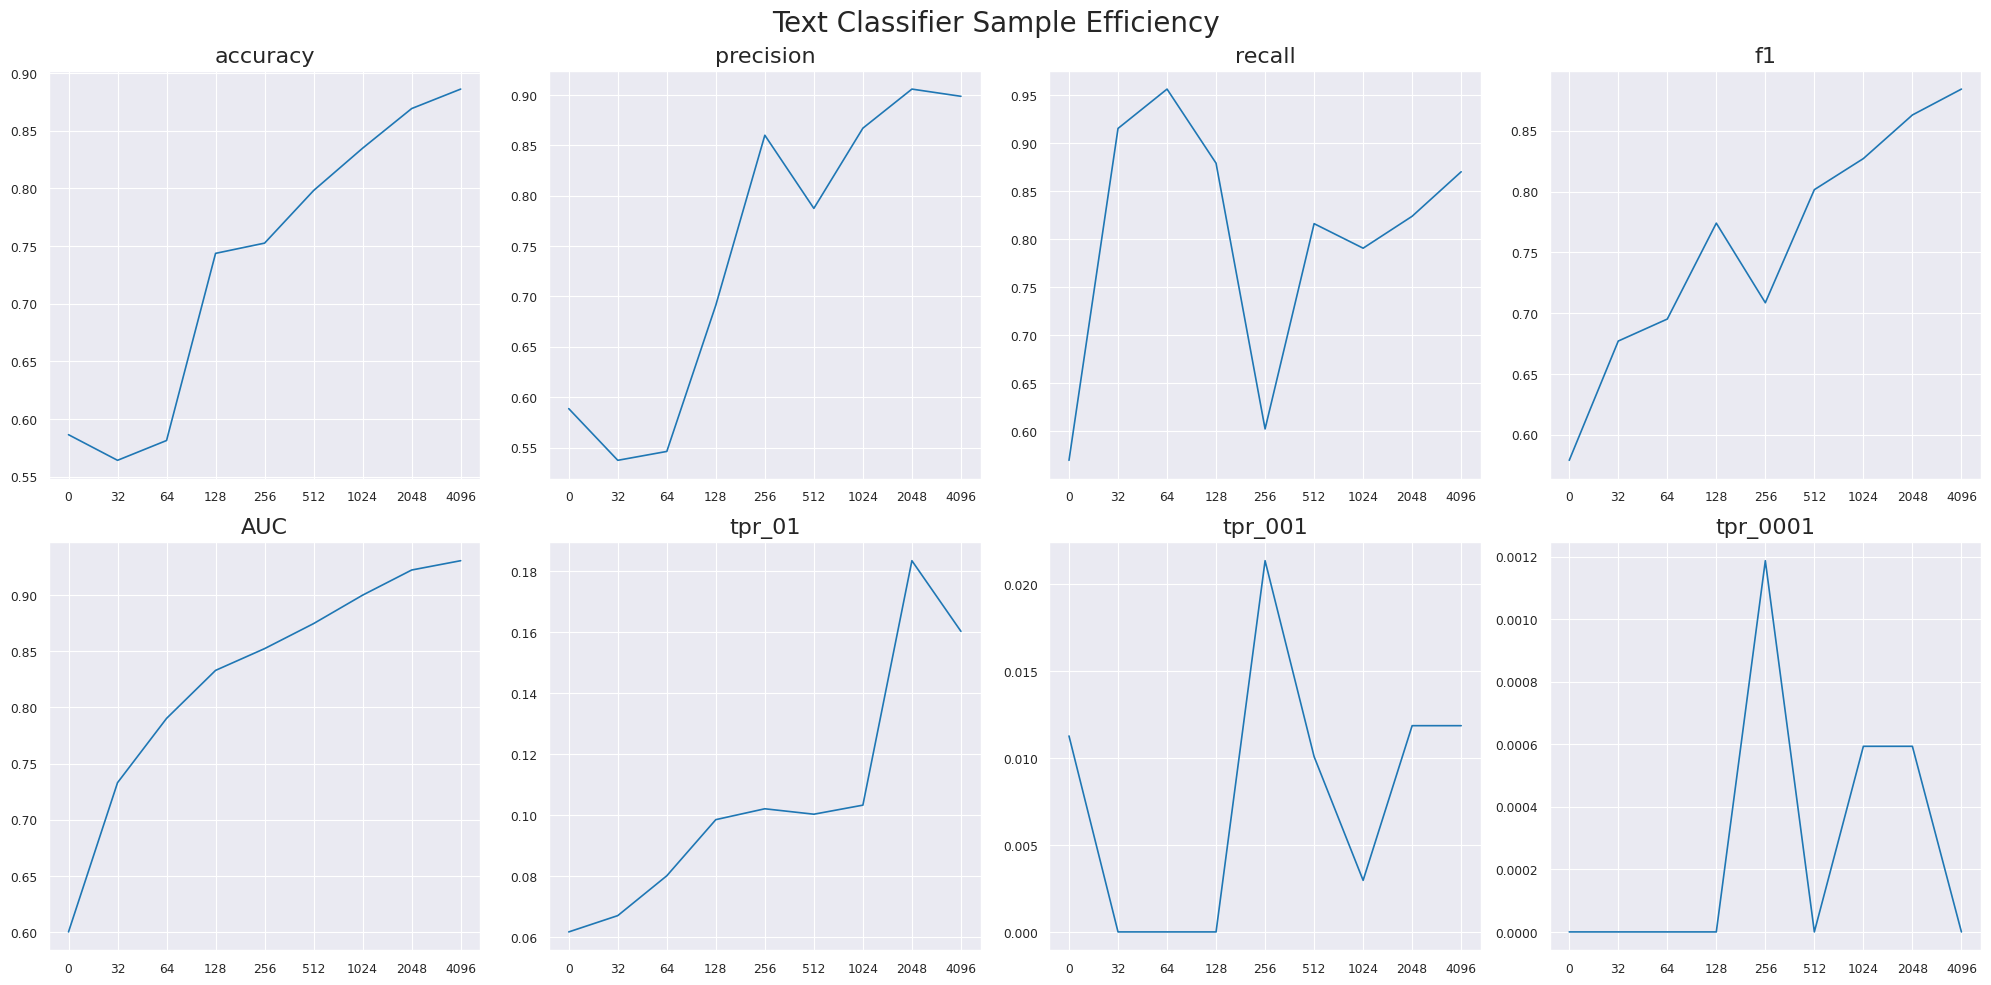

In [27]:
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.set_style('darkgrid')
sns.set_context('paper')

# create 4 x 2 subplots
fig, axes = plt.subplots(2,4, figsize=(20,10))
axes = axes.flatten()

for i, key in enumerate(data.keys()):
    if key == 'val_loss':
        continue
    ax = axes[i-1]
    ax.plot([data[key][x//32] for x in idxs], label=key)
    ax.set_xticks(range(9))
    ax.set_xticklabels(idxs)
     
    ax.set_title(key)
    ax.title.set_fontsize(16)

plt.suptitle("Text Classifier Sample Efficiency", fontsize=20)
plt.tight_layout()
plt.show()